* Froude number plots at peak ebbs and floods.

In [1]:
import numpy as np
import netCDF4 as nc
from salishsea_tools import (nc_tools,viz_tools,tidetools,geo_tools)
import matplotlib.pyplot as plt
import StraTimeSeries as sts
import R_mixStuff as RS
import FroudeNumber as FN
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
sns.set(style="whitegrid")
sns.set_context("notebook", font_scale=1.6, rc={"lines.linewidth": 2.5})
%matplotlib inline

In [2]:
grid6 = nc.Dataset('/ocean/jieliu/research/meopar/river-treatment/bathy_meter_SalishSea6.nc')
X = grid6.variables['nav_lon'][:, :]
Y = grid6.variables['nav_lat'][:, :]
bathy = grid6.variables['Bathymetry'][:, :]
## tmask
mesh = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/oct8_101e061e05/mesh_mask.nc')
tmask = mesh.variables['tmask'][0,:,380:510,240:397]
np_mask = np.abs(1-tmask) 
e3t = mesh.variables['e3t'][0,:,380:510,240:397]

In [3]:
## Jan results
janall_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Jan2016combineall/jan2016all_T.nc','r')
janall_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Jan2016combineall/jan2016all_U.nc','r')
janall_V = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Jan2016combineall/jan2016all_V.nc','r')

## Oct results
octall_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014combineall/oct2014all_T.nc','r')
octall_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014combineall/oct2014all_U.nc','r')
octall_V = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014combineall/oct2014all_V.nc','r')

## May results
mayall_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/May2015combineall/may2015all_T.nc','r')
mayall_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/May2015combineall/may2015all_U.nc','r')
mayall_V = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/May2015combineall/may2015all_V.nc','r')

In [4]:
def determine_plume_method2_onlysalinity(grid_T,tst,ted,dep_ind,ave_flag = False):
    """Similar to method1, but this time the S_ref is the spatial mean 
    of the 2.5*2.5 km in the northern of my subdomain and not plot them, only get the
    threshold salinity"""
    S = grid_T.variables['vosaline']
    lon = grid_T.variables['nav_lon']
    lat = grid_T.variables['nav_lat']
    S_aveN = np.nanmean(S[tst:ted,:,-5:,0:5],axis = 0) ## first temporal average of northern region
    if ave_flag == False:
        S_ref = np.nanmean(S_aveN[dep_ind]) ## then spatial average at specific depth
        S_aveW = np.nanmean(S[tst:ted,dep_ind],axis = 0)
    elif ave_flag == True:
        S_ref = np.nanmean(S_aveN[0:dep_ind+1]) ## then spatial average, including depth
        S_aveW = np.nanmean(np.nanmean(S[tst:ted],axis = 0),axis = 0)
    S_thre = 1.14*S_ref-4.8
    #S_aveW = np.nanmean(S[tst:ted,dep_ind],axis = 0) ## temporal averaged of the whole domain
    S_aveW = np.ma.masked_values(S_aveW, 0) ## mask 0 value
    return S_thre, S_aveW

In [7]:
def calculate_density(t, s):
    """Caluclates the density given temperature in deg C (t)
    and salinity in psu (s).

    returns the density as an array (rho)
    """
    rho = (
        999.842594 + 6.793952e-2 * t
        - 9.095290e-3 * t*t + 1.001685e-4 * t*t*t
        - 1.120083e-6 * t*t*t*t + 6.536332e-9 * t*t*t*t*t
        + 8.24493e-1 * s - 4.0899e-3 * t*s
        + 7.6438e-5 * t*t*s - 8.2467e-7 * t*t*t*s
        + 5.3875e-9 * t*t*t*t*s - 5.72466e-3 * s**1.5
        + 1.0227e-4 * t*s**1.5 - 1.6546e-6 * t*t*s**1.5
        + 4.8314e-4 * s*s)
    return rho

* Calculation

In [56]:
ti = 'all'
ssh = {};T={};S={};u = {};v = {};
t = 196
grid_T = octall_T
grid_U = octall_U
grid_V = octall_V
ssh[ti] = grid_T.variables['sossheig']
T[ti] = grid_T.variables['votemper'][t] ## to calculate rho
T[ti] = np.ma.masked_array(T[ti],mask = np_mask) ## mask 0 values, very important!!! Or density integral is negative sometimes
S[ti] = grid_T.variables['vosaline'][t]
S[ti] = np.ma.masked_array(S[ti],mask= np_mask)
dep = grid_T.variables['deptht']
rho = calculate_density(T[ti],S[ti])

u[ti] = grid_U.variables['vozocrtx']
v[ti] = grid_V.variables['vomecrty']
u[ti],v[ti] = viz_tools.unstagger(u[ti][t],v[ti][t])

In [66]:
U_upper = np.zeros([40,129,156])
V_upper = np.zeros([40,129,156])
U_bottom = np.zeros([40,129,156])
V_bottom = np.zeros([40,129,156])
Rho_upper = np.zeros([40,130,157])
Rho_bottom = np.zeros([40,130,157])
Upper_depthsRho = np.zeros([40,130,157])
Bottom_depthsRho = np.zeros([40,130,157])
Upper_depthsUV = np.zeros([40,129,156])
Bottom_depthsUV = np.zeros([40,129,156])
for j in range(130):
    for i in range(157):
        z_ind = np.nanargmax(np.diff(rho[:,j,i])/np.diff(dep)) ## find max depth index of partial rho/partial z
        for z in range(40):
            if z <= z_ind +1: ## for upper layer rho
                adj_sshRho = 1+ssh[ti][t,j,i]/np.sum(e3t[:,j,i]*tmask[:,j,i],axis = 0)
                Rho_upper[z,j,i] = rho[z,j,i]* e3t[z,j,i]*adj_sshRho*tmask[z,j,i]
                Upper_depthsRho[z,j,i] = e3t[z,j,i]*adj_sshRho*tmask[z,j,i]
                if (j< 129) and (i<156): ## for upper layer velocity, note already unstaggered
                    adj_sshUV = 1+ssh[ti][t,j+1,i+1]/np.sum(e3t[:,j+1,i+1]*tmask[:,j+1,i+1],axis = 0)
                    U_upper[z,j,i] = u[ti][z,j,i]* e3t[z,j+1,i+1]*adj_sshUV * tmask[z,j+1,i+1]
                    V_upper[z,j,i] = v[ti][z,j,i]* e3t[z,j+1,i+1]*adj_sshUV * tmask[z,j+1,i+1]
                    Upper_depthsUV[z,j,i] = e3t[z,j+1,i+1]*adj_sshUV*tmask[z,j+1,i+1]
                    
            if z > z_ind +1: ## bottom layer rho
                adj_sshRho = 1+ssh[ti][t,j,i]/np.sum(e3t[:,j,i]*tmask[:,j,i],axis = 0)
                Rho_bottom[z,j,i] = rho[z,j,i]* e3t[z,j,i]*adj_sshRho*tmask[z,j,i]
                Bottom_depthsRho[z,j,i] = e3t[z,j,i]*adj_sshRho*tmask[z,j,i]
                if (j< 129) and (i<156): ## for bottom layer velocity, note already unstaggered
                    adj_sshUV = 1+ssh[ti][t,j+1,i+1]/np.sum(e3t[:,j+1,i+1]*tmask[:,j+1,i+1],axis = 0)
                    U_bottom[z,j,i] = u[ti][z,j,i]* e3t[z,j+1,i+1]*adj_sshUV * tmask[z,j+1,i+1]
                    V_bottom[z,j,i] = v[ti][z,j,i]* e3t[z,j+1,i+1]*adj_sshUV * tmask[z,j+1,i+1]
                    Bottom_depthsUV[z,j,i] = e3t[z,j+1,i+1] * adj_sshUV * tmask[z,j+1,i+1]       

In [151]:
g= 9.8
rho_0 = 1023.8
## Integral for velocity
U_upperTotal = np.nansum(U_upper,axis = 0)/np.nansum(Upper_depthsUV,axis =0)
V_upperTotal = np.nansum(V_upper,axis = 0)/np.nansum(Upper_depthsUV,axis =0)
U_bottomTotal = np.nansum(U_bottom,axis = 0)/np.nansum(Bottom_depthsUV,axis =0)
V_bottomTotal = np.nansum(V_bottom,axis = 0)/np.nansum(Bottom_depthsUV,axis =0)

Delta_Velocity = np.sqrt((U_upperTotal-U_bottomTotal)**2+(V_upperTotal- V_bottomTotal)**2)
## Integral of rho
Rho_upperTotal = np.nansum(Rho_upper,axis = 0)/np.nansum(Upper_depthsRho,axis = 0)
Rho_bottomTotal = np.nansum(Rho_bottom,axis = 0)/np.nansum(Bottom_depthsRho,axis = 0)
## Reduced gravity
g_prime = g* (Rho_bottomTotal-Rho_upperTotal)/rho_0
g_prime[g_prime<=0]=np.nan ## some unstable numbers in the rivers and boundaries

## Froude number 
Fr = Delta_Velocity/g_prime[1:,1:]

In [179]:
## Reduced gravity is so small!!!
np.nanmax(g_prime) 

0.16003650017345261

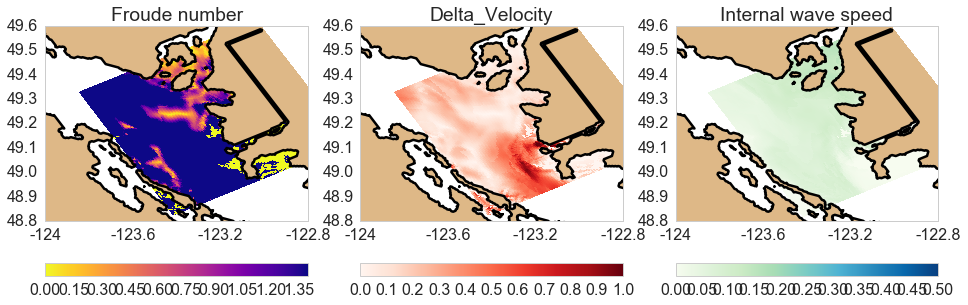

In [180]:
fig,axs =plt.subplots(1,3,figsize = (16,5))
ax= axs[0]
mesh=ax.pcolormesh(lon[1:,1:],lat[1:,1:],Fr,cmap = 'plasma_r',vmin=0, vmax=1.4)
cbar = fig.colorbar(mesh,ax = ax,orientation = 'horizontal')
viz_tools.plot_land_mask(ax,grid6,coords='map',color='burlywood')
viz_tools.plot_coastline(ax, grid6, coords = 'map')
ax.set_title('Froude number')

ax = axs[1]
mesh=ax.pcolormesh(lon[1:,1:],lat[1:,1:],Delta_Velocity,cmap = 'Reds',vmin=0, vmax=1)
cbar = fig.colorbar(mesh,ax = ax,orientation = 'horizontal')
viz_tools.plot_land_mask(ax,grid6,coords='map',color='burlywood')
viz_tools.plot_coastline(ax, grid6, coords = 'map')
ax.set_title('Delta_Velocity')

ax = axs[2]
mesh=ax.pcolormesh(lon[:],lat[:],g_prime,cmap = 'GnBu',vmin=0, vmax=0.5)
cbar = fig.colorbar(mesh,ax = ax,orientation = 'horizontal')
viz_tools.plot_land_mask(ax,grid6,coords='map',color='burlywood')
viz_tools.plot_coastline(ax, grid6, coords = 'map')
ax.set_title('Internal wave speed')
for ax in axs:
    ax.set_xlim([-124.,-122.8])
    ax.set_xticks([-124,-123.6,-123.2,-122.8])
    ax.set_xticklabels([-124,-123.6,-123.2,-122.8])
    ax.set_ylim([48.8,49.6])

(48.7, 49.7)

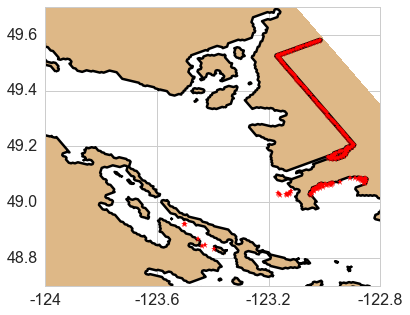

In [149]:
## some unstable grids where reduced gravity is negative
lon = grid_T.variables['nav_lon']
lat = grid_T.variables['nav_lat']
fig ,ax =plt.subplots(1,1,figsize = (6,5))
viz_tools.plot_land_mask(ax,grid6,coords='map',color='burlywood')
viz_tools.plot_coastline(ax, grid6, coords = 'map')
for j in range(130):
    for i in range(157):
        if np.nansum(Rho_bottom,axis = 0)[j,i]/np.nansum(Bottom_depthsRho,axis = 0)[j,i] - \
        np.nansum(Rho_upper,axis = 0)[j,i]/np.nansum(Upper_depthsRho,axis = 0)[j,i] <=0:
            ax.plot(lon[j,i],lat[j,i],'r*') ## cross -strait
ax.set_xlim([-124.,-122.8])
ax.set_xticks([-124,-123.6,-123.2,-122.8])
ax.set_xticklabels([-124,-123.6,-123.2,-122.8])
ax.set_ylim([48.7,49.7])